# Partie ? : Prédiction de la volatilité d'un actif grâce au modèle GARCH

## Préliminaire : installation des bibliothèques

In [231]:
!pip install yfinance
!pip install pandas_datareader
!pip install arch

In [232]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from numpy.linalg import LinAlgError
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from arch import arch_model
sns.set_style('whitegrid')

## Etape 1 : Visualisation des rendements de l'action d'Apple : 'AAPL'

### D'abord nous allons visualiser le cours de l'action

In [282]:
action_nom = 'AAPL'
action_df = yf.download(tickers=action_nom, start='2012-01-01', end='2023-01-29')
action_df.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449693,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516595,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655554,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787855,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767573,394024400


Text(0.5, 1.0, "Cours de l'action d'Apple")

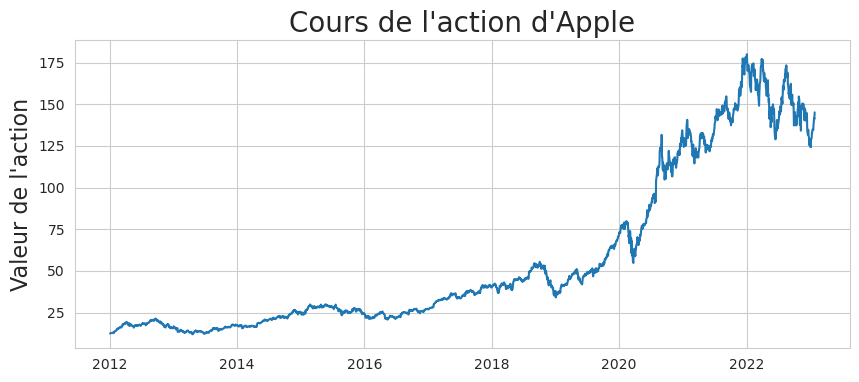

In [283]:
plt.figure(figsize=(10,4))
plt.plot(action_df['Adj Close'])
plt.ylabel('Valeur de l\'action', fontsize=16)
plt.title('Cours de l\'action d\'Apple', fontsize=20)

### Regardons les rendements quotidiens de cette action

Rendement d'une action : 
- $Rendement=100\times\frac{action[Adj\_Close](t+1)-action[Adj\_Close](t)}{action[Adj\_Close](t)}$ 

In [284]:
rendements = 100*action_df['Adj Close'].pct_change().dropna()
rendements

Date
2012-01-04    0.537380
2012-01-05    1.110198
2012-01-06    1.045401
2012-01-09   -0.158602
2012-01-10    0.358021
                ...   
2023-01-23    2.350058
2023-01-24    1.006298
2023-01-25   -0.470065
2023-01-26    1.480337
2023-01-27    1.368422
Name: Adj Close, Length: 2785, dtype: float64

### Tracé des rendements et d'un QQplot

Text(0.02, 0.8, 'Mean:         0.00\nSD:             1.83\nSkew:        -0.47\nKurtosis:    95.41')

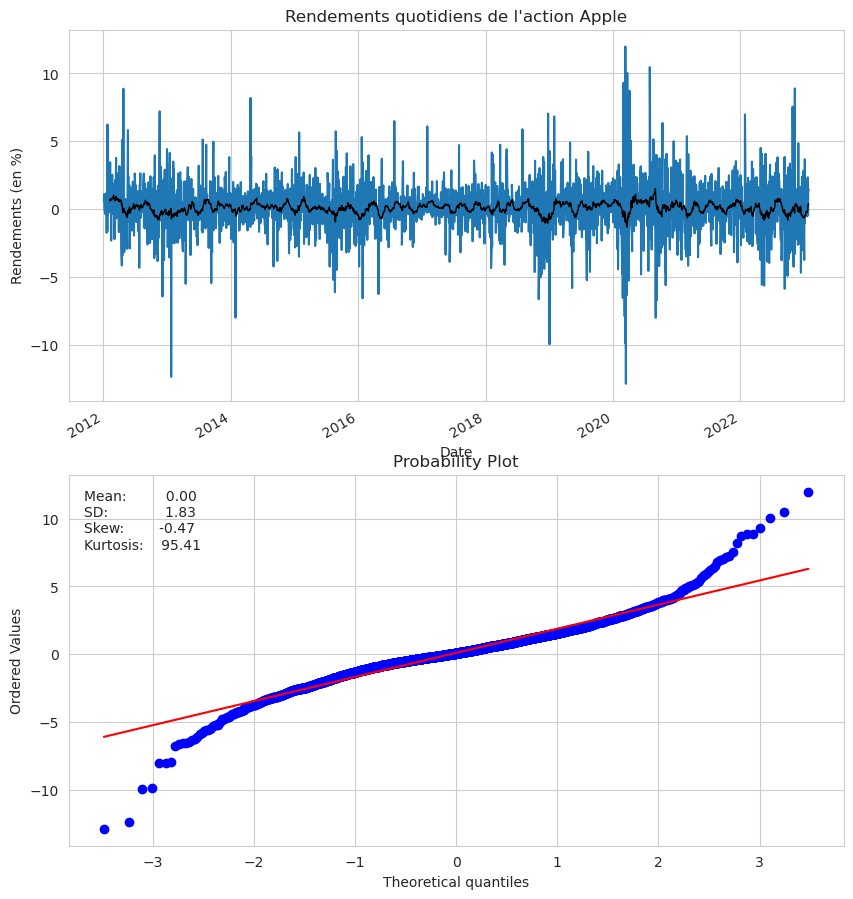

In [285]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
rendements.plot(ax=axes[0], title='Rendements quotidiens de l\'action Apple')
rendements.rolling(25).mean().plot(ax=axes[0], c='k', lw=1)
axes[0].set_ylabel('Rendements (en %)')
probplot(rendements, plot=axes[1])
mean, var, skew, kurtosis = moment(rendements, moment=[1,2,3,4])
s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
axes[1].text(x=0.02, y=0.80, s=s, transform=axes[1].transAxes)

### Visualisation de l'autocorrélation partielle des rendements

L'autocorrélation mesure la corrélation d'une variable avec elle-même, lorsque les observations sont considérées avec un décalage dans le temps (autocorrélation temporelle) ou dans l'espace (autocorrélation spatiale). _Selon l'Insee_.  
  
  Cela nous permettra de déterminer l'ordre de notre modèle GARCH

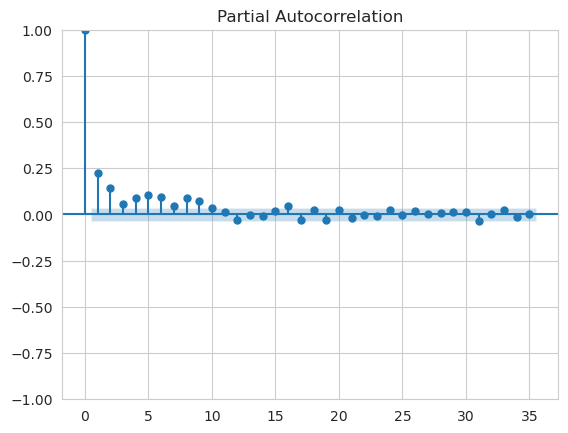

In [286]:
plot_pacf(rendements**2) 
plt.show()

## Etape 2 : Prédiction de volatilité

### D'abord nous allons chercher le meilleur modèle pour notre action

D'après le graphe de l'autocorrélation partiel, on remarque que notre graphe est cohérent jusqu'à la 3ème valeur, ainsi nous allons prendre p=q=3

In [287]:
modele = arch_model(rendements, p=3, q=3)
modele_fit = modele.fit()
modele_fit

Iteration:      1,   Func. Count:     10,   Neg. LLF: 17622.849305280928
Iteration:      2,   Func. Count:     23,   Neg. LLF: 881092.798124448
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5650.987316210549
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5491.723541106009
Iteration:      5,   Func. Count:     55,   Neg. LLF: 5503.756508698901
Iteration:      6,   Func. Count:     65,   Neg. LLF: 5535.430239575705
Iteration:      7,   Func. Count:     75,   Neg. LLF: 5405.733681315041
Iteration:      8,   Func. Count:     85,   Neg. LLF: 5406.591146752144
Iteration:      9,   Func. Count:     95,   Neg. LLF: 5449.735850887439
Iteration:     10,   Func. Count:    106,   Neg. LLF: 5405.434107943062
Iteration:     11,   Func. Count:    116,   Neg. LLF: 5405.04423763148
Iteration:     12,   Func. Count:    125,   Neg. LLF: 5405.050715094263
Iteration:     13,   Func. Count:    135,   Neg. LLF: 5405.210769257086
Iteration:     14,   Func. Count:    145,   Neg. LLF: 5405.005243

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5405.00
Distribution:                  Normal   AIC:                           10826.0
Method:            Maximum Likelihood   BIC:                           10873.5
                                        No. Observations:                 2785
Date:                Thu, Dec 28 2023   Df Residuals:                     2784
Time:                        16:59:38   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1805  3.306e-02      5.460  4.771e-08 [  0.116,  0.24

On remarque que de nombreux coefficients sont non significatifs à hauteur de 15%, le modèle n'est pas optimale. On choisit p et q de sorte à ce qu'ils soient significatifs à 1%  
Après plusieurs fit on trouve p=3, q=0

In [288]:
rolling_predictions = []
taille_test = 1000

for i in range(taille_test):
    train = rendements[:-(taille_test-i)]
    modele = arch_model(train, p=4, q=0)
    modele_fit = modele.fit(disp='off')
    pred = modele_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [289]:
rolling_predictions = pd.Series(rolling_predictions, index=rendements.index[-1000:])

### Visualisation du modèle

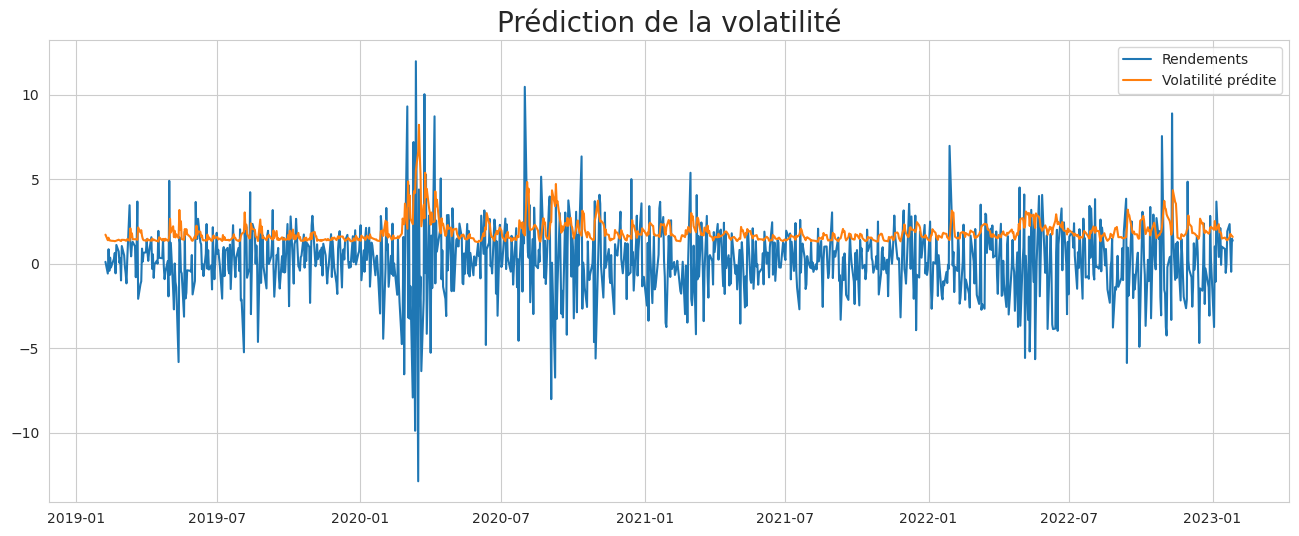

In [290]:
plt.figure(figsize=(16,6))
plt.plot(rendements[-1000:])
plt.plot(rolling_predictions)
plt.title('Prédiction de la volatilité', fontsize=20)
plt.legend(['Rendements', 'Volatilité prédite'], fontsize=10)

On voit bien dans ce graphe que la volatilité predite suit bien les variations des rendements de l'action, le modèle parait satisfaisant.

## Etape 3 : Utilisation du modèle 

### Nous allons maintenant utiliser le modèle pour trouver la volatilité à horizon d'un jour et d'une semaine

#### Horizon d'un jour :

In [291]:
donnes_entrainement = rendements
modele = arch_model(donnes_entrainement, p=3, q=0)
modele_fit = model.fit(disp='off')
pred = modele_fit.forecast(horizon=3)
dates_futures = [rendements.index[-1] + timedelta(days=i) for i in range(1,4)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=dates_futures)

Text(0.5, 1.0, 'Prediction de la volatilité pour le prochain jour')

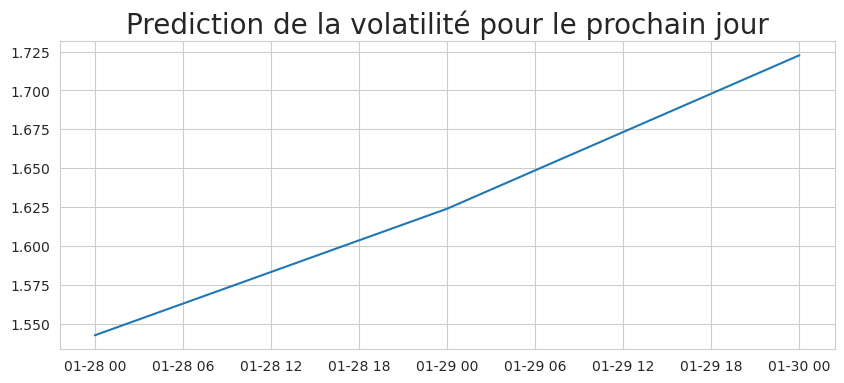

In [292]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Prediction de la volatilité pour le prochain jour', fontsize=20)

Regarder la volatilité a horizon d'un jour ne permet pas de se rendre compte précisemment des variations du cours de l'action

#### Horizon d'une semaine

In [293]:
pred_2 = modele_fit.forecast(horizon=7)
dates_futures_2 = [rendements.index[-1] + timedelta(days=i) for i in range(1,8)]
pred_2 = pd.Series(np.sqrt(pred_2.variance.values[-1,:]), index=dates_futures_2)

Text(0.5, 1.0, 'Prediction de la volatilité pour les 7 prochains jours')

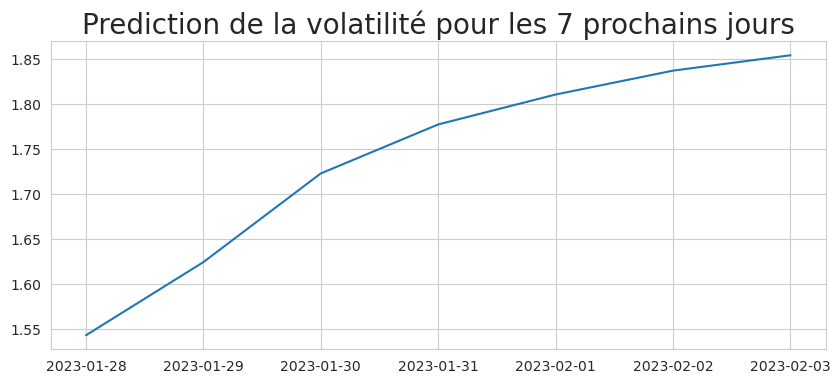

In [294]:
plt.figure(figsize=(10,4))
plt.plot(pred_2)
plt.title('Prediction de la volatilité pour les 7 prochains jours', fontsize=20)

## Etape 4 : Vérification de cette prédiction

### Nous allons voir si les prédictions sur 7 jours correspondent à la réalité

In [295]:
action_df_verif = yf.download(tickers=action_nom, start='2023-01-27', end='2023-02-05')
action_df_verif.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-27,143.160004,147.229996,143.080002,145.929993,145.118851,70555800
2023-01-30,144.960007,145.550003,142.850006,143.000000,142.205154,64015300
2023-01-31,142.699997,144.339996,142.279999,144.289993,143.487961,65874500
2023-02-01,143.970001,146.610001,141.320007,145.429993,144.621628,77663600
2023-02-02,148.899994,151.179993,148.169998,150.820007,149.981674,118339000


Text(0.5, 1.0, "Cours de l'action d'Apple")

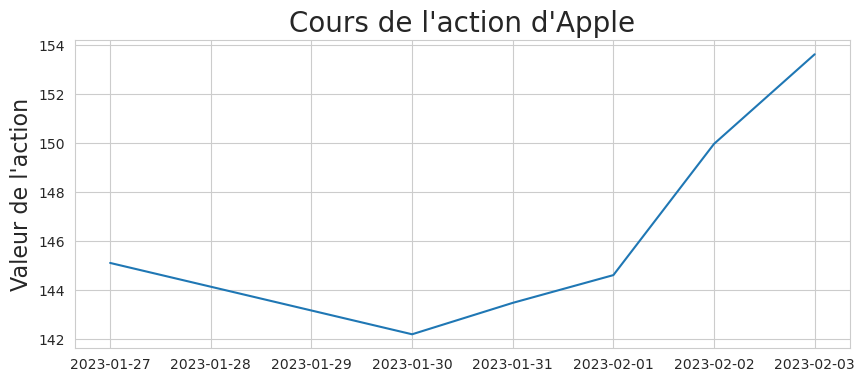

In [296]:
plt.figure(figsize=(10,4))
plt.plot(action_df_verif['Adj Close'])
plt.ylabel('Valeur de l\'action', fontsize=16)
plt.title('Cours de l\'action d\'Apple', fontsize=20)

Ainsi on est censé s'attendre à une hausse de la volatilité puis une baisse

Text(0.5, 1.0, 'Prediction de la volatilité pour les 7 prochains jours')

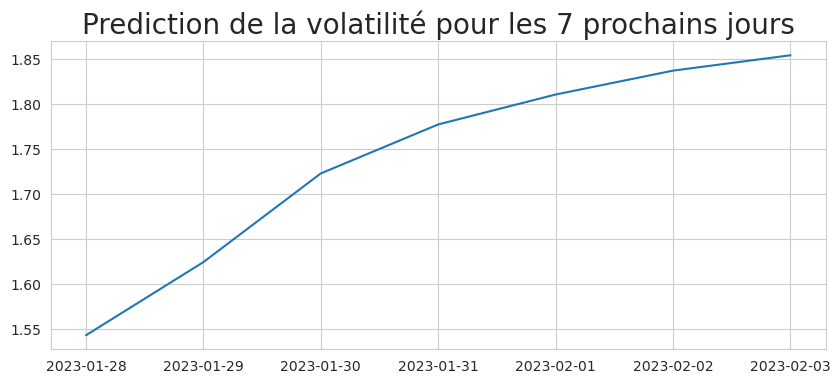

In [297]:
plt.figure(figsize=(10,4))
plt.plot(pred_2)
plt.title('Prediction de la volatilité pour les 7 prochains jours', fontsize=20)

On voit bien que du 27 au 31 janvier 2023, le cours d'Apple varie assez peu entre 142 et 145 alors que du 1 au 3 février 2023 l'action varie entre 145 et 154. La volatilité a augmenté entre ces 2 périodes ce qui se reflète bien dans nos prédictions. 

### Attention : Ce n'est pas parce que le modèle est vérifié pour cette semaine là que ce sera vrai dans tous les cas. Le modèle n'est pas synonyme de réalité !